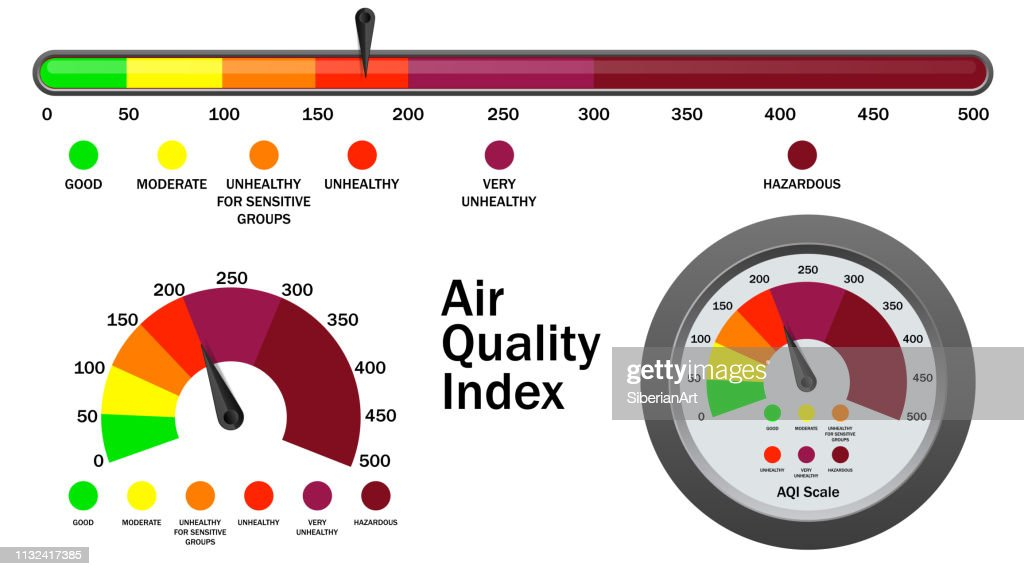

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [2]:
data= pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx', parse_dates=[['Date', 'Time']])
data.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
data.shape

(9357, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date_Time      9357 non-null   datetime64[ns]
 1   CO(GT)         9357 non-null   float64       
 2   PT08.S1(CO)    9357 non-null   float64       
 3   NMHC(GT)       9357 non-null   int64         
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   float64       
 6   NOx(GT)        9357 non-null   float64       
 7   PT08.S3(NOx)   9357 non-null   float64       
 8   NO2(GT)        9357 non-null   float64       
 9   PT08.S4(NO2)   9357 non-null   float64       
 10  PT08.S5(O3)    9357 non-null   float64       
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 1023.5 KB


In [5]:
data.rename(columns = {'PT08.S4(NO2)':'PT08_S4_NO2'}, inplace = True)

In [6]:
data.corr()['PT08_S4_NO2']

CO(GT)          -0.073721
PT08.S1(CO)      0.845133
NMHC(GT)         0.162689
C6H6(GT)         0.774649
PT08.S2(NMHC)    0.874761
NOx(GT)          0.035580
PT08.S3(NOx)     0.122672
NO2(GT)         -0.022092
PT08_S4_NO2      1.000000
PT08.S5(O3)      0.723670
T                0.755053
RH               0.640685
AH               0.691889
Name: PT08_S4_NO2, dtype: float64

The matrix of regression variables X will contain two variables:
* Temperature T
* Absolute Humidity AH

### STEP 1: Prepare the data

In [7]:
type(data['Date_Time'])

pandas.core.series.Series

In [8]:
data['DateTimeIndex']= pd.to_datetime(data['Date_Time'])
data = data.set_index(keys=['DateTimeIndex'])

Set the frequency attribute of the index to Hourly. This will create several empty rows corresponding to the missing hourly measurements in the original data set. Fill up all the empty data cells with the mean of the corresponding column.

In [9]:
ata = data.asfreq('H')
data = data.fillna(data.mean(numeric_only=True))
data.shape

(9357, 14)

In [10]:
data.isin([np.nan, np.inf, -np.inf]).sum()

Date_Time        0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08_S4_NO2      0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [11]:
dataset_len = len(data)
split_index = round(dataset_len*0.9)
train_set_end_date = data.index[split_index]

In [12]:
df_train = data.loc[data.index <= train_set_end_date].copy()
df_test = data.loc[data.index > train_set_end_date].copy()

### STEP 2: Create a Linear Regression model

In [13]:
from patsy import dmatrices
expr = 'PT08_S4_NO2 ~ T + AH'

In [14]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

### Ordinary Least Squares Linear Regression model

In [15]:
from statsmodels.regression import linear_model

olsr = linear_model.OLS(y_train, X_train).fit()

In [16]:
olsr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08_S4_NO2   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     7969.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        17:23:49   Log-Likelihood:                -59426.
No. Observations:                8422   AIC:                         1.189e+05
Df Residuals:                    8419   BIC:                         1.189e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1113.6844      7.218    154.302      0.000    1099.536    1127.833
T             20.5513      0.365     56.237      0.000      19.835      21.268
AH           -13.9624      0.405    -34.444      0.000     -14.757     -13.168
==============================================================================
Omnibus:                      904.777   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.196
Skew:                           0.785   Prob(JB):                    6.02e-307
Kurtosis:                       4.247   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression coefficients of both regression variables T and AH are significant at a 99.99% confidence level as indicated by their P values (P > |t| column) which are essentially 0.

The second thing to note in these results is the output of the Durbin-Watson test which measures the degree of LAG-1 auto-correlation in the residual errors of regression. A value of 2 implies no LAG-1 auto-correlation. A value closer to 0 implies strong positive auto-correlation while a value close to 4 implies a strong negative auto-correlation at LAG-1 among the residuals errors ε.

In the above output, we see that the DW test statistic is 0.28 indicating a strong positive auto-correlation among the residual errors of regression at LAG-1. This was completely expected since the underlying data is a time series and the linear regression model has failed to explain the auto-correlation in the dependent variable. The DW test statistic just confirms it.

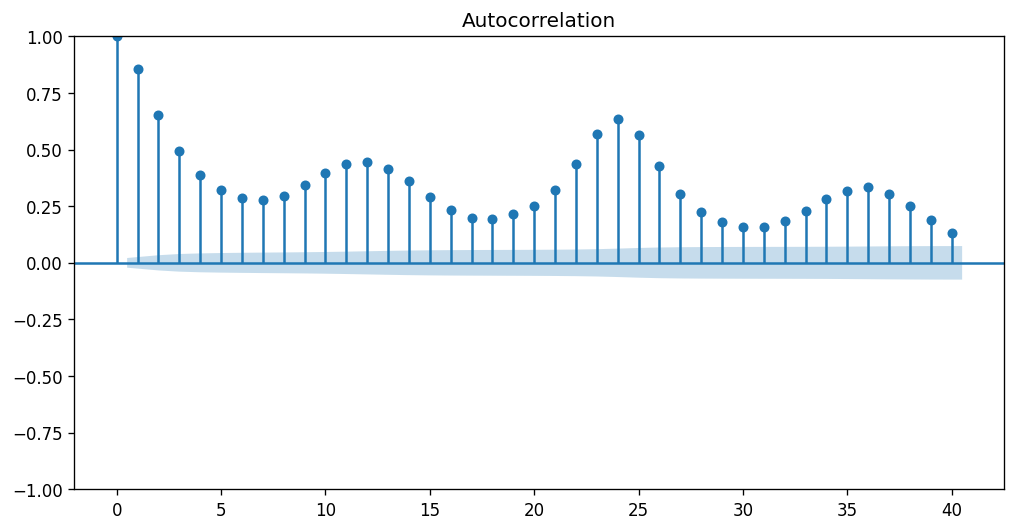

In [17]:
import statsmodels.graphics.tsaplots as tsa

plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

tsa.plot_acf(olsr.resid, alpha=0.05)
plt.show()

The ACF tells us three things:

* There are strong auto-correlations extending out to multiple lags indicating that the residual errors time series has a trend. We’ll need to de-trend this time series by using one or possibly 2 orders of differencing. Thus, the parameter d is likely to be 1, or possibly 2.
* The wavelike pattern in the ACF evidences a seasonal variation in the data.
* The peak at LAG = 24 indicates that the seasonal period is likely to be 24 hours. i.e. m is likely to be 24. This seems reasonable for data containing vehicular pollution measurements. We’ll soon verify this guess using the time series decomposition plot.

### Before we estimate the rest of the (S)ARIMA parameters, let’s difference the time series once i.e. d=1:

In [18]:
olsr.resid.head(2)

DateTimeIndex
2004-03-10 18:00:00    309.398174
2004-03-10 19:00:00    181.863043
dtype: float64

In [19]:
olsr_resid_diff_1 = olsr.resid.diff()
olsr_resid_diff_1.head(2)

DateTimeIndex
2004-03-10 18:00:00           NaN
2004-03-10 19:00:00   -127.535131
dtype: float64

In [20]:
olsr_resid_diff_1.isnull().sum()

1

In [21]:
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

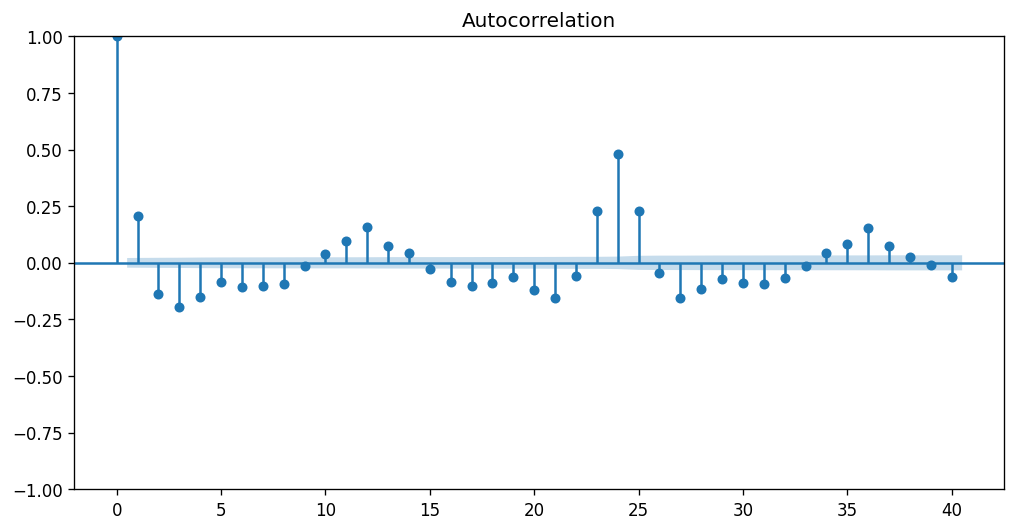

In [22]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)
plt.show()

We now see a very different picture in the ACF. The auto-correlations are significantly reduced at all lags. The wavelike pattern still exists but that’s because we did nothing to remove the possible seasonal variation. The LAG-24 auto-correlation is once again especially prominent.

We see that there is still a significant auto-correlation at LAG-1 in the differenced time series. We could try extinguishing it by taking one more difference, i.e. d=2 and plotting the resulting time series’ ACF:

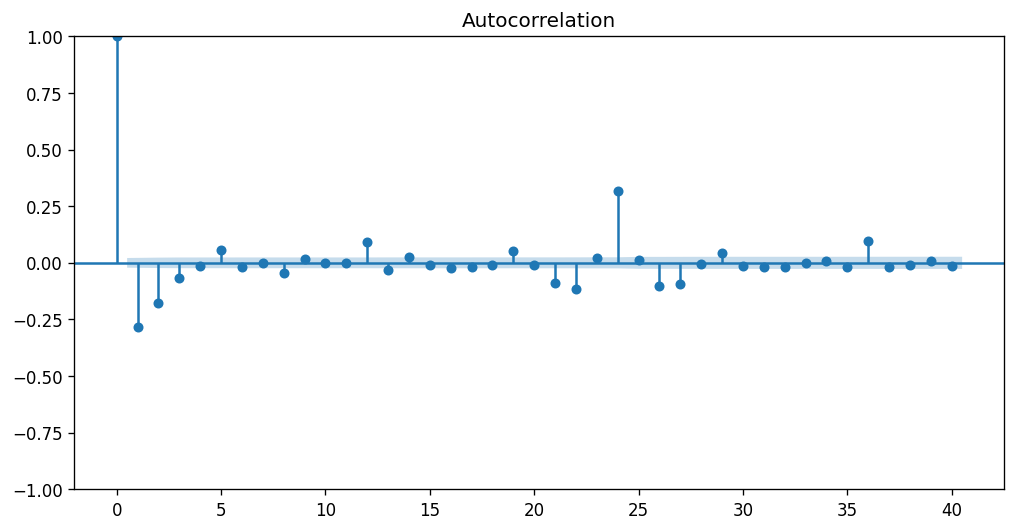

In [23]:
olsr_resid_diff_2 = olsr_resid_diff_1.diff()
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()

plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
tsa.plot_acf(olsr_resid_diff_2, alpha=0.05)
plt.show()

Differing the time series a second time has produced a heavy negative auto-correlation at LAG-1. This is bad sign. We seem to have over-done the differencing. We should stick with d=1.

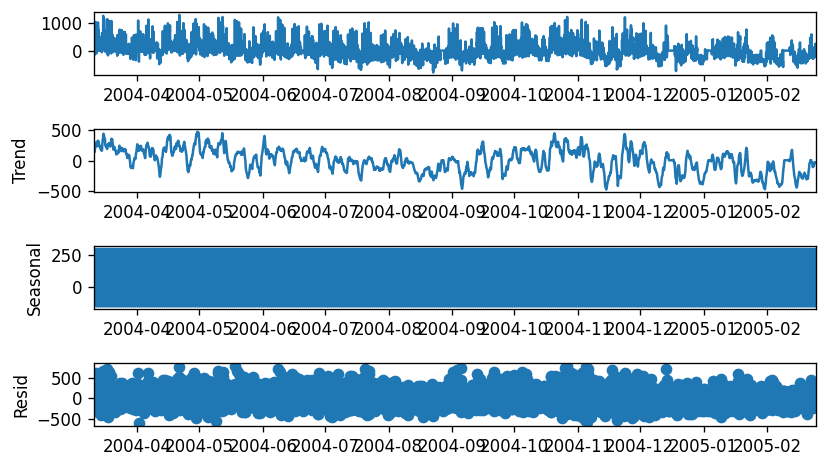

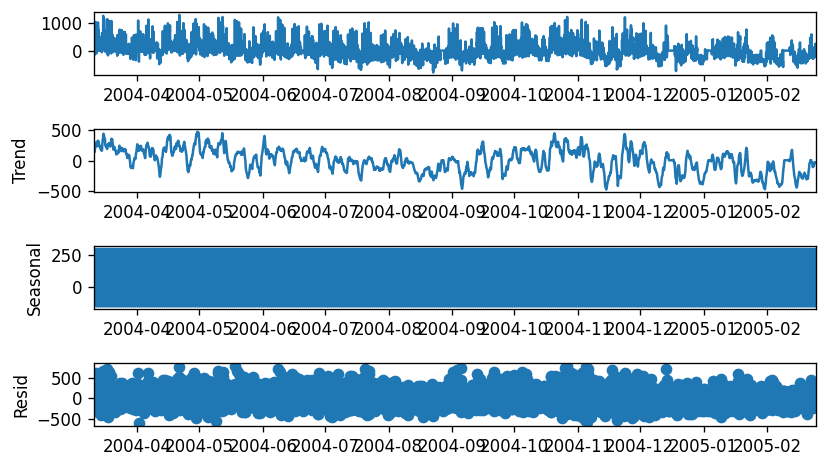

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(olsr.resid)

plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':120})
components.plot()

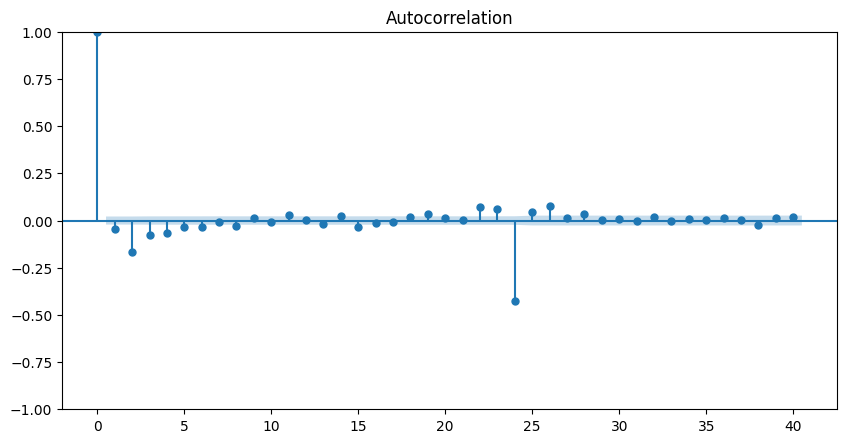

In [25]:
olsr_resid_diff_1_24 = olsr_resid_diff_1.diff(periods=24)
olsr_resid_diff_1_24 = olsr_resid_diff_1_24.dropna()

plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})

tsa.plot_acf(olsr_resid_diff_1_24, alpha=0.05)
plt.show()

The strong negative correlation at LAG-24 indicates a Seasonal MA (SMA) signature with order 1. i.e. Q=1. Moreover, an absence of positive correlation at LAG-1, indicates an absence of a Seasonal AR component. i.e. P=0.

We have fixed P=0, D=1 and Q=1, and m=24 hours

We have managed to estimate all 7 params of the SARIMA model as follows: p=1, d=1, q=0, P=0, D=1, Q=1 and m=24 i.e. 
SARIMAX(1,1,0)(0,1,1)24

# STEP 4: Build and fit the Regression Model with Seasonal ARIMA errors


In [26]:
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('H')

In [27]:
y_train = y_train.asfreq('H')

In [28]:
from statsmodels.tsa.arima.model import ARIMA
sarimax_model = ARIMA(endog=y_train,
                      exog=X_train_minus_intercept, 
                      order=(1,1,0), 
                      seasonal_order=(0,1,1,24))

In [29]:
sarimax_results = sarimax_model.fit()

In [30]:
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -51815.958
Date:                            Tue, 31 May 2022   AIC                         103641.916
Time:                                    17:24:53   BIC                         103677.094
Sample:                                03-10-2004   HQIC                        103653.928
                                     - 02-24-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -4.6351      0.628     -7.383      0.000      -5.865      -3.405
AH            13.3304      0.673     19.808      0.000      12.011      14.649
ar.L1         -0.0041      0.008     -0.519      0.604      -0.020       0.011
ma.S.L24      -0.9184      0.003   -281.217      0.000      -0.925      -0.912
sigma2      1.334e+04    124.277    107.318      0.000    1.31e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5180.05
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
sarimax_model = ARIMA(endog=y_train, 
                      exog=X_train_minus_intercept,
                      order=(1,1,0), 
                      seasonal_order=(0,1,0,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -53887.658
Date:                          Tue, 31 May 2022   AIC                         107783.315
Time:                                  17:24:58   BIC                         107811.458
Sample:                              03-10-2004   HQIC                        107792.925
                                   - 02-24-2005                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -4.9003      0.688     -7.123      0.000      -6.249      -3.552
AH            13.6175      0.738     18.442      0.000      12.170      15.065
ar.L1         -0.0519      0.008     -6.482      0.000      -0.068      -0.036
sigma2      2.195e+04    208.195    105.422      0.000    2.15e+04    2.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              4288.52
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## STEP 5: Prediction

In [32]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('H')
y_test = y_test.asfreq('H')

In [33]:
predictions = sarimax_results.get_forecast(steps=24, exog=X_test_minus_intercept[:24])
predictions.summary_frame().head()

PT08_S4_NO2,mean,mean_se,mean_ci_lower,mean_ci_upper
2005-02-24 16:00:00,1286.066400,148.149772,995.698183,1576.434617
2005-02-24 17:00:00,1308.454485,204.153164,908.321635,1708.587335
2005-02-24 18:00:00,1345.693115,248.033957,859.555492,1831.830738
2005-02-24 19:00:00,1376.087728,285.232092,817.043100,1935.132356
2005-02-24 20:00:00,1388.823150,318.110281,765.338456,2012.307845


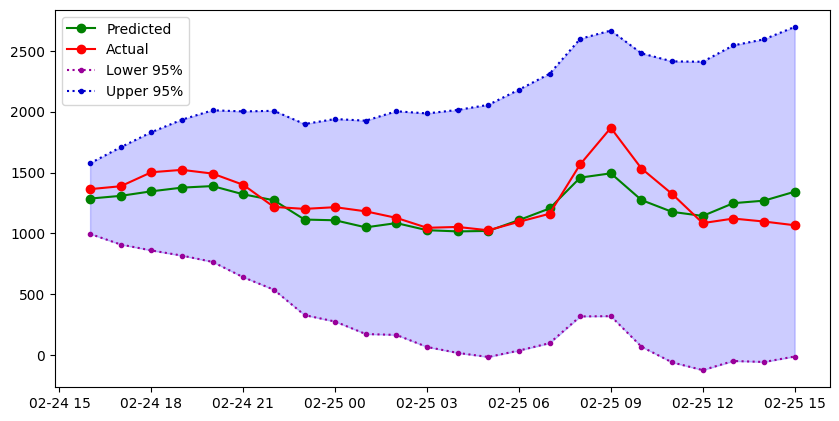

In [34]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})

predicted, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')

actual,  = plt.plot( y_test[:24], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])
plt.show()

# ARIMA model

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

### Find the order of differencing (d) in ARIMA model

In [36]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


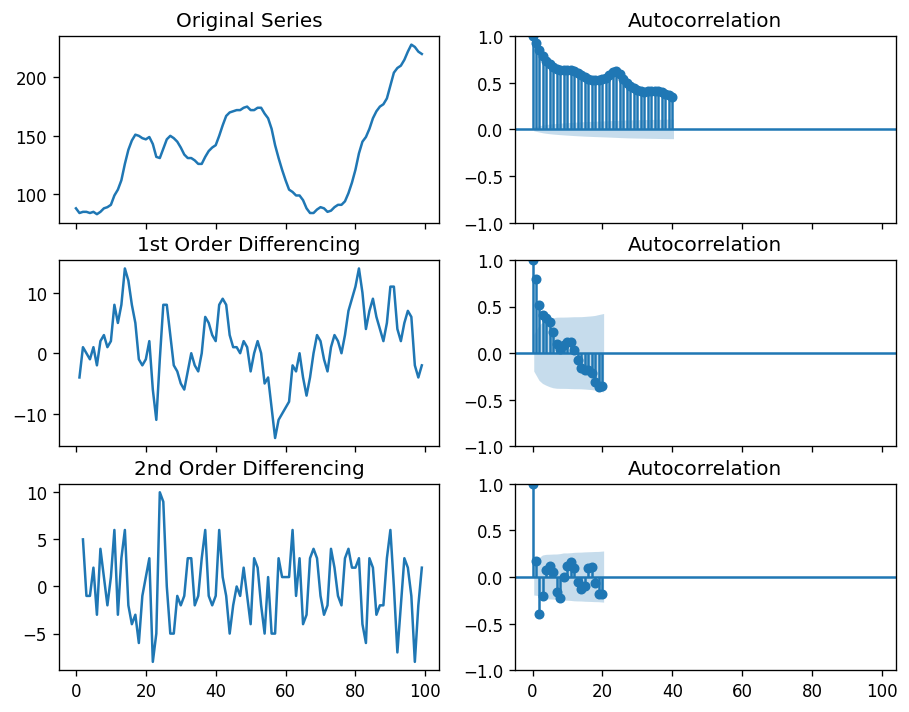

In [37]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(data[['PT08_S4_NO2']], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Auto Arima Forecast

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.00 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

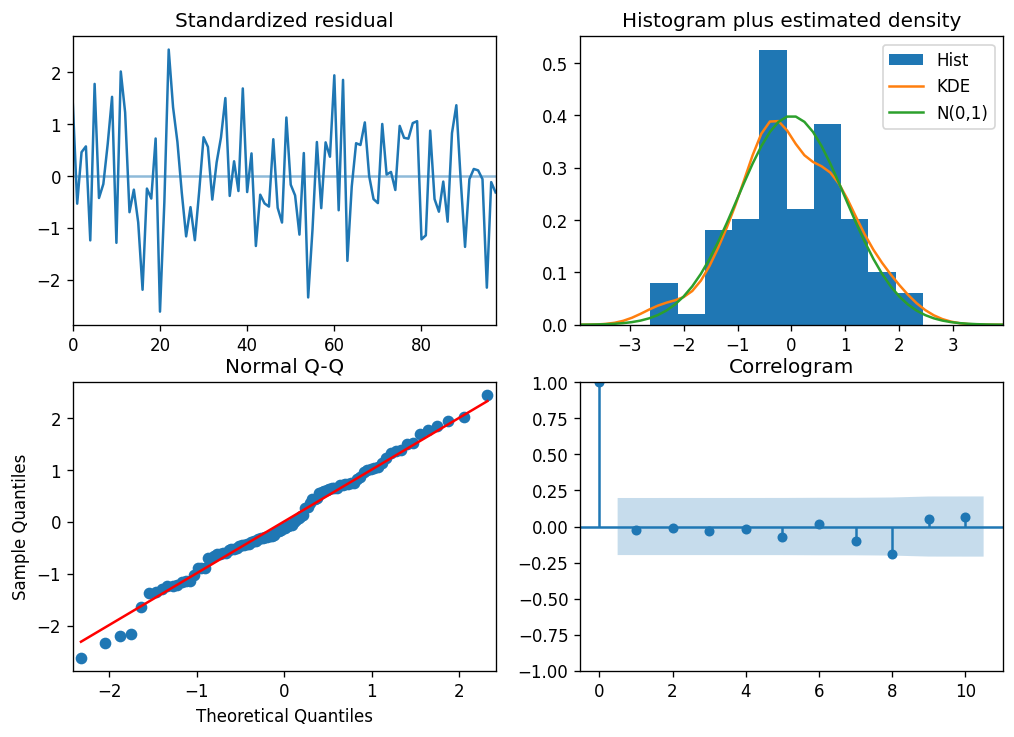

In [39]:
model.plot_diagnostics(figsize=(10,7))
plt.show()

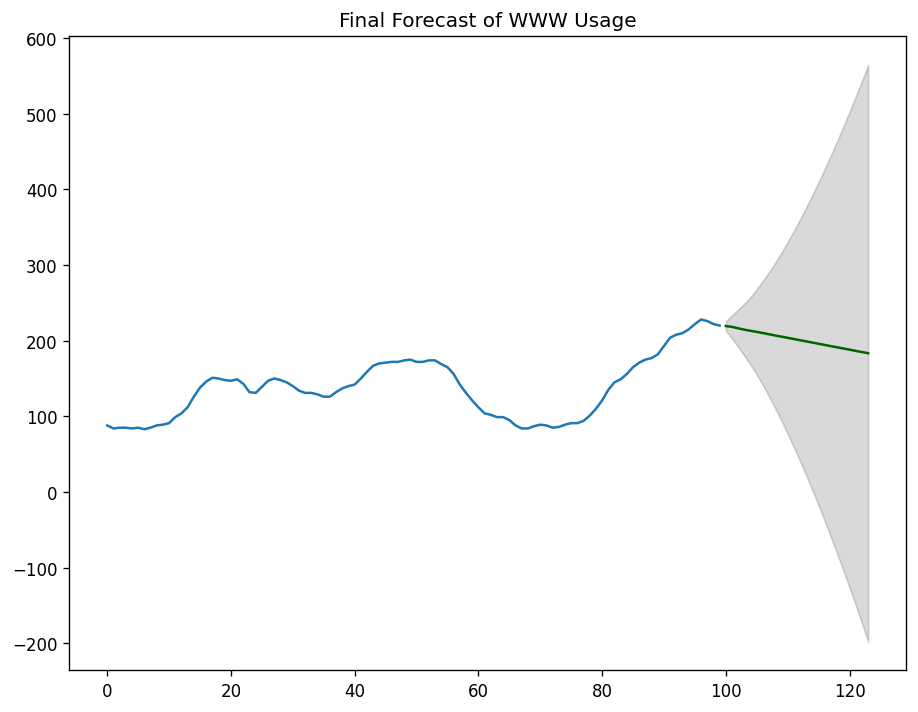

In [40]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of WWW Usage")
plt.show()